# Visualização do Aprendizado em CNN – MNIST

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# 1. Carregamento e pré-processamento do MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 2. Definição de dois modelos: com e sem Dropout

In [3]:
def criar_modelo_cnn(dropout=False):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    if dropout:
        model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 3. Treinamento dos dois modelos

In [4]:
model_sem_dropout = criar_modelo_cnn(dropout=False)
hist_sem = model_sem_dropout.fit(x_train, y_train_cat,
                                  validation_split=0.2,
                                  epochs=10,
                                  batch_size=128,
                                  verbose=0)

model_com_dropout = criar_modelo_cnn(dropout=True)
hist_com = model_com_dropout.fit(x_train, y_train_cat,
                                  validation_split=0.2,
                                  epochs=10,
                                  batch_size=128,
                                  verbose=0)

# 4. Gráficos comparativos

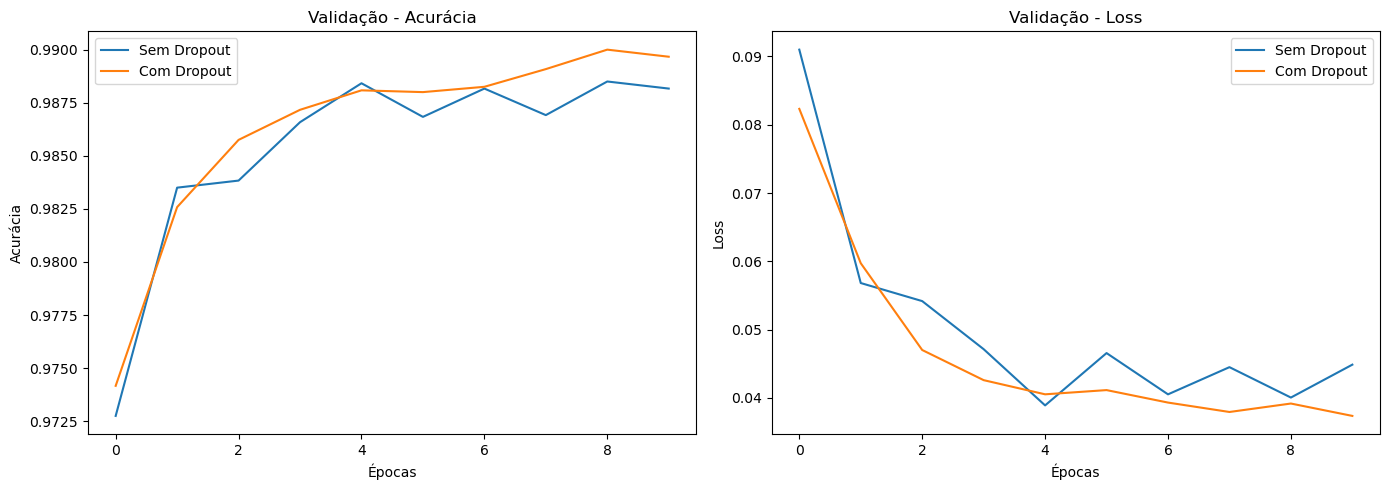

In [5]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_sem.history['val_accuracy'], label='Sem Dropout')
plt.plot(hist_com.history['val_accuracy'], label='Com Dropout')
plt.title('Validação - Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_sem.history['val_loss'], label='Sem Dropout')
plt.plot(hist_com.history['val_loss'], label='Com Dropout')
plt.title('Validação - Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Visualização de filtros da primeira camada convolucional

Formato dos filtros: (3, 3, 1, 32)


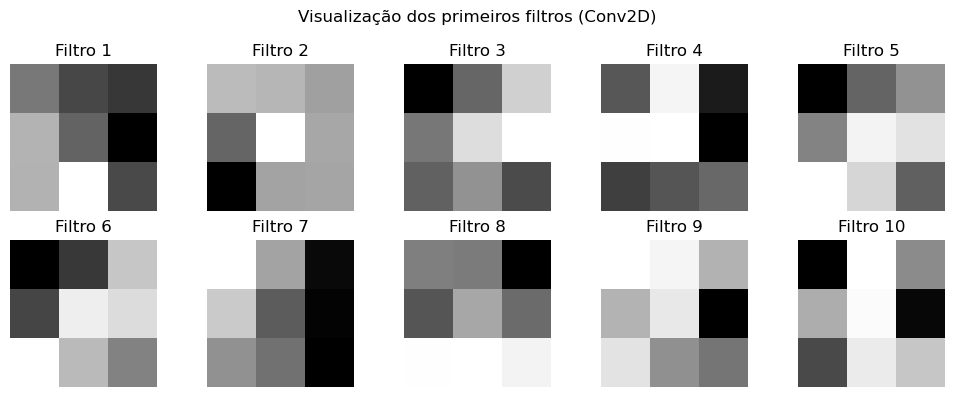

In [12]:
# 5. Visualização de filtros da primeira camada convolucional (forma segura)
from tensorflow.keras.layers import Conv2D

# Localiza a primeira camada Conv2D com segurança
first_layer_weights = None
for layer in model_com_dropout.layers:
    if isinstance(layer, Conv2D):
        first_layer_weights = layer.get_weights()[0]
        break

# Confirma se foi encontrada
if first_layer_weights is not None:
    print(f"Formato dos filtros: {first_layer_weights.shape}")  # (3, 3, 1, 32)

    plt.figure(figsize=(10, 4))
    for i in range(10):
        filtro = first_layer_weights[:, :, 0, i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(filtro, cmap='gray')
        plt.title(f"Filtro {i+1}")
        plt.axis('off')
    plt.suptitle("Visualização dos primeiros filtros (Conv2D)")
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma camada Conv2D encontrada no modelo.")

# 6. Mapa de ativação da primeira camada para uma imagem de teste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


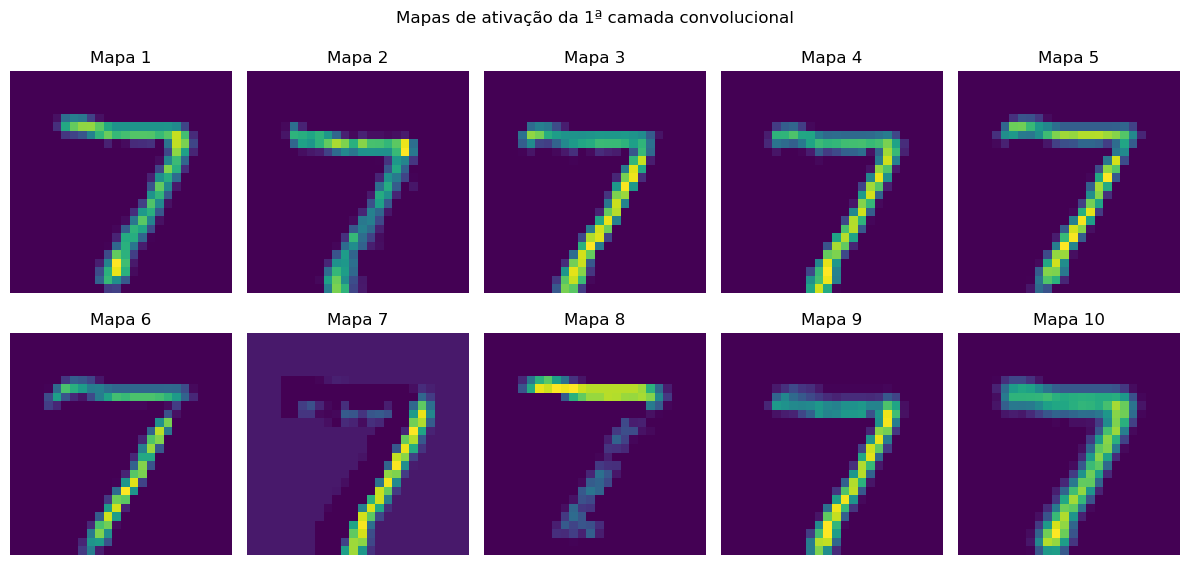

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt

# Força construção do modelo (caso não tenha sido feito)
_ = model_com_dropout.predict(x_test[:1])

# Recupera a entrada e saída da primeira camada Conv2D diretamente
# usando o método .get_layer() com nome ou índice confiável

primeira_conv = None
for layer in model_com_dropout.layers:
    if isinstance(layer, Conv2D):
        primeira_conv = layer
        break

if primeira_conv is not None:
    # Cria modelo de ativação a partir da saída da camada convolucional
    model_ativacao = Model(inputs=model_com_dropout.layers[0].input,  # input real da primeira camada
                           outputs=primeira_conv.output)

    img = x_test[0:1]
    ativacoes = model_ativacao.predict(img)

    # Visualiza os 10 primeiros mapas
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(ativacoes[0, :, :, i], cmap='viridis')
        plt.title(f"Mapa {i+1}")
        plt.axis("off")
    plt.suptitle("Mapas de ativação da 1ª camada convolucional")
    plt.tight_layout()
    plt.show()
else:
    print("Não foi encontrada uma camada Conv2D.")


# 7. Conclusão
print("""
✅ Conclusão

Neste experimento, comparamos duas CNNs: uma com e outra sem Dropout. Através dos gráficos, foi possível observar que o modelo **sem Dropout** tende a apresentar maior overfitting, enquanto o **com Dropout** mantém a validação mais estável.

Além disso, visualizamos os **filtros aprendidos** na primeira camada convolucional e os **mapas de ativação** para uma imagem real. Esses recursos mostram como a rede aprende a detectar padrões simples nas primeiras camadas, como bordas e formas.

A visualização ajuda a entender melhor como as CNNs funcionam internamente e reforça a importância de técnicas de regularização como Dropout.

Este tipo de análise é um passo importante para construir redes mais profundas, interpretar o aprendizado e justificar decisões em aplicações reais.
""")